In [1]:
import pandas as pd
pd.options.plotting.backend = "plotly"

# Measurements

In [2]:
filepath = '../../data/all_JPL_v5.csv'
measurements = pd.read_csv(filepath,index_col=0,comment='#',parse_dates=True)
measurements

,Load,Persist1Workday
Datetime,,
2018-10-09 00:00:00,0.000000,0.0
2018-10-09 00:15:00,0.000000,0.0
2018-10-09 00:30:00,0.000000,0.0
2018-10-09 00:45:00,0.000000,0.0
2018-10-09 01:00:00,0.000000,0.0
...,...,...
2020-01-19 22:45:00,31.878070,0.0
2020-01-19 23:00:00,31.498684,0.0
2020-01-19 23:15:00,31.030568,0.0


# Forecasts

In [3]:
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse/'
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_v1.2/'
#filepath = '/home/mjw/Code/LSTMforecast/moresultsdels/bayfield_jail-courthouse_random-search/'
#filepath = '/home/mjw/Code/LSTMforecast/results/bayfield_jail-courthouse_random-search/'
#filepath = '../models/bayfield_jail-courthouse_i96_o96_imf4569_rmWKEND_u128-128_d0.1-0.1/'
#filepath = r'C:\Users\Admin\Code\LSTMforecast\results\jpl_ev_v1.4\u256-256_d0_in96_flen4'
filepath = '../../results/jpl_ev_v1.4/u256-256_d0_in96_flen4/'

forecast = pd.read_csv(filepath+r'all_forecasts.csv',index_col=0)

forecast['timestamp_update'] = pd.to_datetime(forecast['timestamp_update'])
forecast['timestamp'] = pd.to_datetime(forecast['timestamp'])
forecast['weekday'] = forecast['timestamp_update'].dt.dayofweek

first_monday = forecast.loc[forecast['weekday'] == 0,'timestamp_update'].iloc[0]

forecast = forecast.loc[forecast['timestamp_update'].values >= first_monday,:]

forecast

,Pred,Load,Persist,timestamp_update,timestamp,weekday
96,3.011272,0.000000,0.000000,2019-12-30,2019-12-30 00:00:00,0
97,3.677077,0.000000,0.000000,2019-12-30,2019-12-30 00:15:00,0
98,2.946970,0.000000,0.000000,2019-12-30,2019-12-30 00:30:00,0
99,1.024361,0.000000,0.000000,2019-12-30,2019-12-30 00:45:00,0
100,0.787941,0.000000,0.000000,2019-12-30,2019-12-30 01:00:00,0
...,...,...,...,...,...,...
1243,4.021924,15.250812,15.942982,2020-01-15,2020-01-15 22:45:00,2
1244,6.415482,15.279543,15.927074,2020-01-15,2020-01-15 23:00:00,2
1245,3.675139,15.240757,15.931579,2020-01-15,2020-01-15 23:15:00,2
1246,4.287410,15.257294,7.729258,2020-01-15,2020-01-15 23:30:00,2


# Forecast mix w/ persist

O 0, H1 0, H2 24, Mean daily skill: 29%, Daily Skills >0: 67%
O 0, H1 8, H2 17, Mean daily skill: 27%, Daily Skills >0: 75%


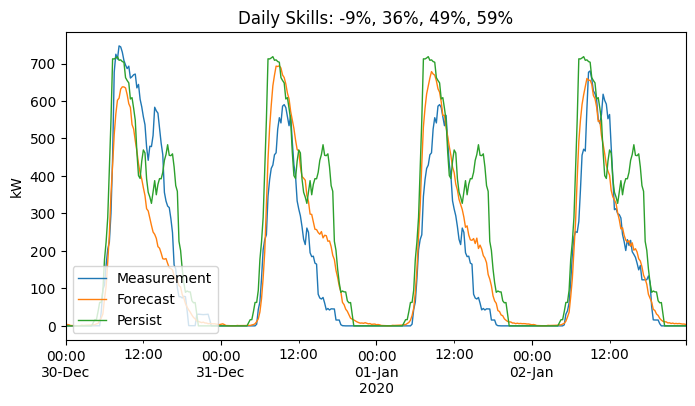

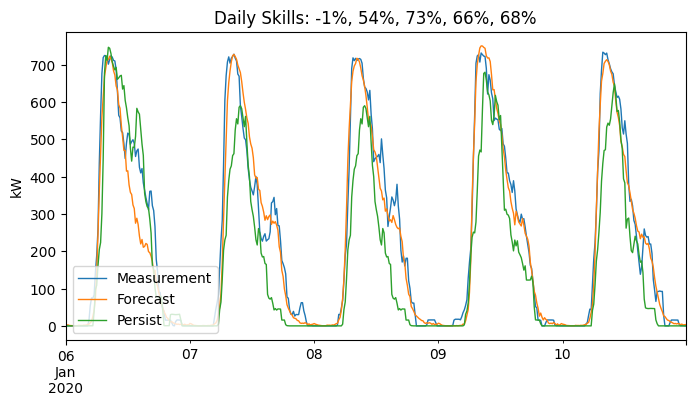

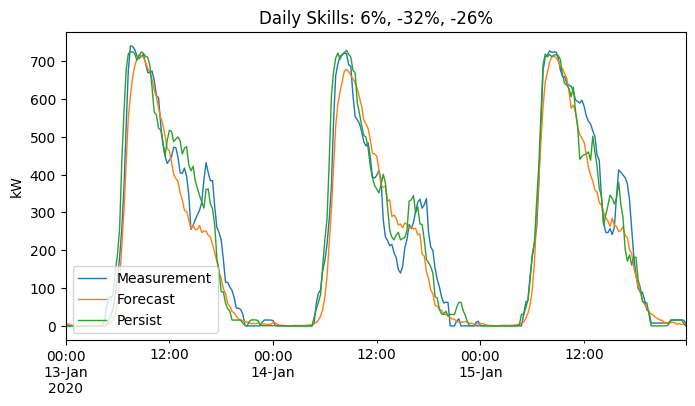

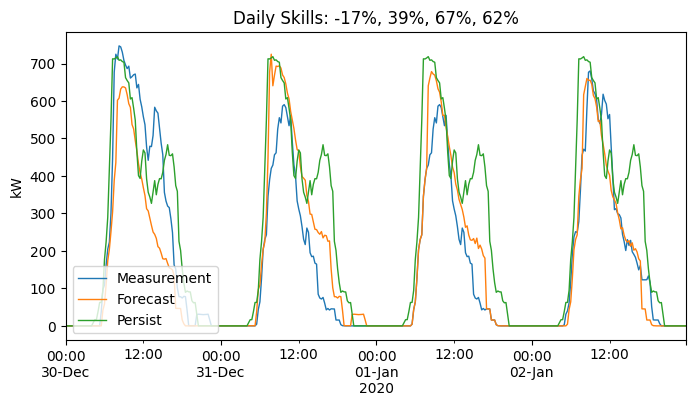

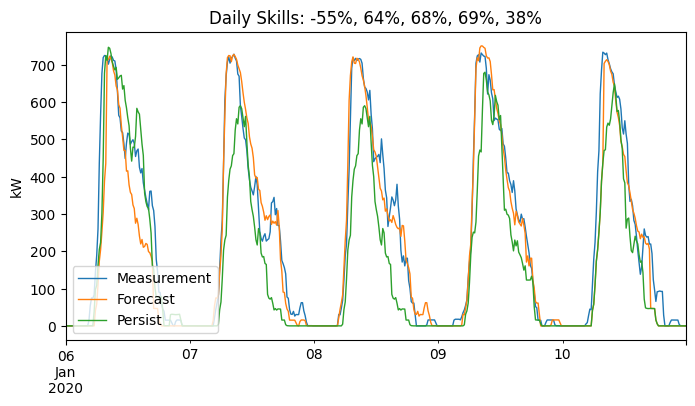

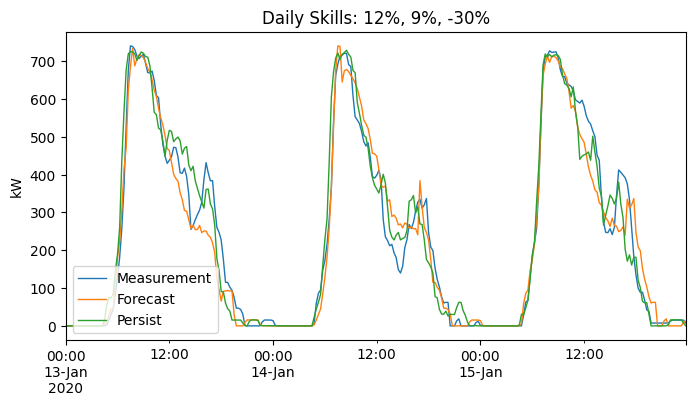

In [184]:
pd.options.plotting.backend = 'matplotlib'

def calc_skill_mae(ytrue,ypred,ybench):
    return 1 - (ytrue - ypred).abs().mean() / (ytrue - ybench).abs().mean()

def forecast_mix(forecast:pd.DataFrame,mix:pd.Series,h_offset=0,h1=None,h2=None,
                 limit_wks=None,plot=False,output=True,first_x_hours_persist=False,
                 figsize=(20,8)):
    f = forecast
    m = mix
    
    skills,skills_wk = [],[]
    
    if h1 is None: h1 = 0
    if h2 is None: h2 = 24
    
    h_persist_replace = list(range(h1)) + list(range(h2,24))
    
    if type(limit_wks) != list:
        wks = [x for x in f.timestamp_update.dt.isocalendar().week.unique()[:limit_wks]]
    else:
        wks = limit_wks
        
    for wk in wks:
        
        #t0 = f['timestamp_update'].iloc[0] + pd.Timedelta(f'{h_offset}h') + wk*pd.Timedelta(f'7d')

        yweek = pd.DataFrame([])
        skills_wk = []

        #for t in pd.date_range(t0,periods=5,freq='1d'):
        #for t in [t for t in forecast.timestamp_update.unique() if (t.hour==0 and t.minute==0)]:
        #for t in f.timestamp_update.unique()[wk*7:wk*7+5]:
        for t in f.timestamp_update[f.timestamp_update.dt.isocalendar().week==wk].unique():
            idx = f[f.timestamp_update==t].index
            idx_times = f.loc[idx,'timestamp'].values
            #print(idx_times)
            yday = pd.DataFrame({   'Measurement':  f.loc[idx,'Load'].values, 
                                    'Forecast':     f.loc[idx,'Pred'].values,
                                    'Persist':      f.loc[idx,'Persist'].values,
                                    'ForecastMix':  m.loc[idx_times].values,
                                           },
                                    index=          idx_times)

            if first_x_hours_persist:
                yday.loc[t:t+pd.Timedelta(hours=first_x_hours_persist),'Forecast'] \
                    = yday.loc[t:t+pd.Timedelta(hours=first_x_hours_persist),'ForecastMix'].values

            # mix forecast with mix_col
            yday.loc[yday.index.hour.isin(h_persist_replace),'Forecast'] \
                = yday.loc[yday.index.hour.isin(h_persist_replace),'ForecastMix'].values

            yweek = pd.concat((yweek,yday),axis=0)

            skill_mae = calc_skill_mae(yday.Measurement,yday.Forecast,yday.Persist)
            skills.append(skill_mae)
            skills_wk.append(skill_mae)
        
        yweek = yweek.interpolate()
        
        skills_wk = ', '.join([f'{100*sk:.0f}%' for sk in skills_wk if not pd.isna(sk)])

        if plot:
            yweek.drop(columns=['ForecastMix']).plot(title=f'Daily Skills: {skills_wk}',
            #yweek.plot(title=f'Daily Skills: {skills_wk}',
                       figsize=figsize,
                       linewidth=1,
                       ylabel='kW',
                       xlabel='',
                       ).legend(loc='lower left')

    s = pd.Series(skills).dropna()
    if output:
        print(f"O {h_offset}, H1 {h1}, H2 {h2}, Mean daily skill: {100*s.mean():.0f}%, Daily Skills >0: {100*s[s.values>0].count()/len(s):.0f}%")
        
    return s

forecast_mix(forecast,measurements.Persist1Workday,
             h_offset=0,
             #h1=8,
             #h2=17,
             plot=True,
             #limit_wks=[3],
             figsize=(8,4));


forecast_mix(forecast,measurements.Persist1Workday,
             h_offset=0,
             h1=8,
             h2=17,
             plot=True,
             #limit_wks=[3],
             figsize=(8,4));

## Grid search

In [171]:
results = pd.DataFrame([],columns=['offset','h1','h2','skills_mean','skills_pos'])
for h_offset in [0]:#[0,4,8,12,16,20]:
    for h1 in range(0,25):
        for h2 in range(0,25):
            if h2>(h1+4):
                s = forecast_mix(forecast,measurements.Persist1Workday,h_offset,h1,h2,plot=False,output=False)
                results.loc[len(results)] = [h_offset,h1,h2,round(s.mean(),3),round(s[s.values>0].count()/len(s),3)]
                

results.to_csv(f'mix_lstm_persist_grid_search.csv')
results.sort_values('skills_mean',ascending=False)#.head(5)
